In [1]:
import re
import numpy as np
import pybedtools as bt
import pandas as pd
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from collections import defaultdict, Counter

import cluster_zfps as cz # soft-linked from scripts directory

np.random.seed(379397)

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Futura'
mpl.rcParams['savefig.transparent'] = True

# Defining kznf clusters
kznfs are known to form tandemly repeated clusters in mammalian genomes. In this project, we would like to analyze the composition and regulatory activity of these clusters, in order to better understand the behaviour of kznfs in development and disease states. To begin, we will simply define clusters based on their spatial organisation within the genome. To do this, using the method previously used by Tribolet-Hardy (2017) and Huntley (2006), defining clusters as containing at least 3 kznfs whose midpoints are separated by <= 250kb.

In [2]:
# Define some global data structures storing kznf coordinates etc.
t2t_genomefile = '../data/genomes/GCF_009914755.1.genome'

with open(t2t_genomefile) as infile:
    chr_lengths = {l.split()[0]: (0, int(l.split()[1])) for l in infile}

with open('../data/genomes/GCF_009914755.1.chrom_accessions.txt') as infile:
    acc_to_chr = {l.split()[0]: l.split()[1] for l in infile}

def plot_clusters(zf_bed, cluster_bed, chr_accession, saveas=None):
    """Plot KZNF clusters and underlying ZNF density"""
    zf_colnames = ['a_chrom', 'a_start', 'a_stop', 'a_name', 'a_score', 'a_strand', 'a_source', 'a_type', 'a_tmp', 'a_desc']
    cluster_colnames = ['b_chrom', 'b_start', 'b_stop', 'b_name', 'b_score', 'b_strand', 'b_desc']
    cluster_df = zf_bed.intersect(cluster_bed, wa=True, wb=True).to_dataframe(names=zf_colnames+cluster_colnames)
    cluster_df = cluster_df.loc[cluster_df.b_chrom == chr_accession]
    
    fig, ax = plt.subplots(figsize=(11, 1))
    sns.kdeplot(cluster_df, 
            x='a_start', 
            lw=1,
            bw_method=0.01,
            color='k',
            ax=ax)
    sns.rugplot(data=cluster_df, 
                x='a_start',
                hue='b_name',
                height=0.1, 
                palette='twilight',
                ax=ax)
    
    for _, cluster in cluster_df[cluster_colnames].drop_duplicates().iterrows():
        
        start, stop = cluster.b_start, cluster.b_stop
        if cluster.b_score < 3:
            rect = patches.Rectangle((start, 0), stop-start, 2e-7, facecolor='whitesmoke')
        else:
            rect = patches.Rectangle((start, 0), stop-start, 2e-7, facecolor='#D9E0EA')
            ax.text(x=start + (stop-start)/2, y=1.8e-7, s=f'{cluster.b_score}', ha='center')
        ax.add_patch(rect)
    
    ax.set_ylabel('ZNF density')
    ax.set_xlim((chr_lengths[chr_accession][0], chr_lengths[chr_accession][1]))
    ax.set_xlabel(f'Chromosome {acc_to_chr[chr_accession]} position (bp)')
    ax.get_legend().remove()
    sns.despine()
    if saveas:
        plt.savefig(saveas, bbox_inches='tight')
    plt.show()


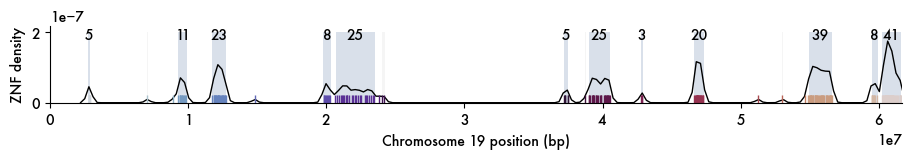

In [3]:
kznf_bed = bt.BedTool('../data/gffs/kzfp_genes_only.bed').sort()
hs_genome = cz.ZFGenome(kznf_bed, '../data/genomes/GCF_009914755.1.genome', use_midpoint=True)
kznf_cluster_bed = hs_genome.extract_zf_clusters(2.5e5)
plot_clusters(kznf_bed, kznf_cluster_bed, 'NC_060943.1', '../figures/chr19_kznf_clusters.svg')

# Analysis of KZNF clusters
Having defined clusters based on inter-ZNF distances, we would like to begin analyzing the composition of clusters and comparing with that of the rest of the genome. Specifically, we ask the following questions:

1. Is the TE content of ZKFP clusters higher than expected relative to random regions of the genome?
2. Are TEs within clusters younger than the rest of the genome?
3. Are specific TE families enriched in clusters?

In [4]:
# Load TEs
print('loading TE bed')
te_bed = bt.BedTool('../data/repeatmasker-out/Homo_sapiens/GCF_009914755.1_T2T-CHM13v2.0_rm.bed')
# Remove clusters with < 3 members and subtract kznf CDSs from clusters
print('processing kznf clusters')

kznf_observations_bed = kznf_cluster_bed \
    .filter(lambda x: int(x[4]) >= 3) \
    .sort() \
    .subtract(kznf_bed)

# Extract 50kb windows around gene CDSs, merge and subtract CDS regions
print('processing control genes')
other_genes_bed = bt.BedTool('../data/gffs/GCF_009914755.1_T2T-CHM13v2.0_CDS.gff')
control_genes_bed = other_genes_bed \
    .sort() \
    .slop(g=t2t_genomefile,
          b=5e4) \
    .merge() \
    .subtract(b=kznf_cluster_bed) \
    .subtract(b=other_genes_bed)

# Shuffle windows from kznf
print('processing random controls')
random_bed = kznf_observations_bed \
    .shuffle(g=t2t_genomefile)

# Split each dataset into 10kb chunks
print('making windows')
kznf_observations_bed = kznf_observations_bed.makewindows(w=1e4, b=kznf_observations_bed)
control_genes_bed = control_genes_bed.makewindows(w=1e4, b=control_genes_bed)
random_bed = random_bed.makewindows(w=1e4, b=random_bed)

loading TE bed
processing kznf clusters
processing control genes
processing random controls
making windows


In [5]:
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = '--'

def calc_repeat_coverage(teclasses):
    # Extract TE coverage from each and convert to dataframe. This step is slow, unfortunately.
    print('calculating KZNF coverage')
    kznf_observations_df = kznf_observations_bed.coverage(b=te_bed.filter(lambda x: x[10].split('/')[0] in teclasses)).to_dataframe()
    print('calculating gene coverage')
    control_genes_df = control_genes_bed.coverage(b=te_bed.filter(lambda x: x[10].split('/')[0] in teclasses)).to_dataframe()
    print('calculating random coverage')
    random_df = random_bed.coverage(b=te_bed.filter(lambda x: x[10].split('/')[0] in teclasses)).to_dataframe()
    
    # Concat dataframes
    print('Processing experiment_df')
    kznf_observations_df['group'] = 'kznf_clusters'
    control_genes_df['group'] = 'other_genes'
    random_df['group'] = 'random'
    
    coverage_experiment_df = pd.concat([
        kznf_observations_df,
        control_genes_df,
        random_df,
    ]).rename({'thickStart': 'te_coverage'}, axis=1)[['chrom', 'start', 'end', 'te_coverage', 'group']]
    coverage_experiment_df['te_coverage'] *= 100
    
    # Remove non-full-length windows to avoid skewing with 100%/0% small windows.
    coverage_experiment_df['window_len'] = coverage_experiment_df['end'] - coverage_experiment_df['start']
    coverage_experiment_df = coverage_experiment_df.loc[coverage_experiment_df.window_len == 1e4].drop('window_len', axis=1)
    
    return coverage_experiment_df

def plot_coverage(coverage_experiment_df):
    other_genes_pval = stats.ranksums(coverage_experiment_df.loc[coverage_experiment_df.group == 'kznf_clusters', 'te_coverage'],
                                      coverage_experiment_df.loc[coverage_experiment_df.group == 'other_genes', 'te_coverage'])
    random_pval = stats.ranksums(coverage_experiment_df.loc[coverage_experiment_df.group == 'kznf_clusters', 'te_coverage'],
                                 coverage_experiment_df.loc[coverage_experiment_df.group == 'random', 'te_coverage'])
    
    fig, ax = plt.subplots(figsize=(3, 3))
    
    plt.text(x=0.5, y=105, s=f'p = {other_genes_pval.pvalue:.0e}', ha='center', size=8)
    plt.text(x=1.5, y=105, s=f'p = {random_pval.pvalue:.0e}', ha='center', size=8)
    plt.plot((0.1, 0.9), (104, 104), color='k', lw=1)
    plt.plot((1.1, 1.9), (104, 104), color='k', lw=1)
    sns.boxplot(data=coverage_experiment_df, 
                x='group', 
                y='te_coverage', 
                hue='group',
                legend=False,
                palette=['#E7D595', '#BFC588', '#9FC9A4'],
                notch=True,
                ax=ax)
    
    
    ax.set_xlabel('')
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['KZNF\nclusters', 'other\ngenes', 'random\nsequence'])
    ax.set_ylabel('TE coverage (%)')
    sns.despine()
    
    return fig, ax

calculating KZNF coverage
calculating gene coverage
calculating random coverage
Processing experiment_df


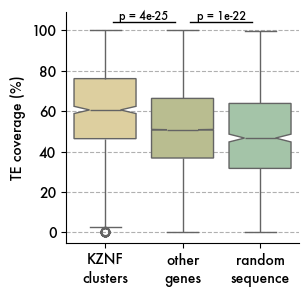

In [6]:
coverage_experiment_df = calc_repeat_coverage(['LTR', 'LINE', 'SINE', 'DNA', 'DNA?', 'Unknown', 'RC'])
fig, ax = plot_coverage(coverage_experiment_df)
plt.savefig('../figures/kznf_te_coverage.svg', bbox_inches='tight')
plt.show()

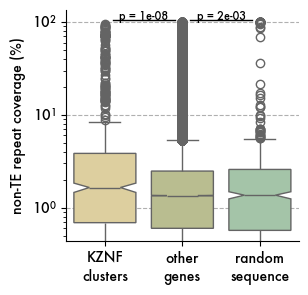

In [16]:
# coverage_experiment_df = calc_repeat_coverage(['scRNA', 'Retroposon', 'Simple_repeat', 
#                                                'Unspecified', 'rRNA', 'srpRNA', 
#                                                'tRNA', 'snRNA', 'Satellite', 
#                                                'Low_complexity'])
fig, ax = plot_coverage(coverage_experiment_df)
ax.set_yscale('log')
ax.set_ylabel('non-TE repeat coverage (%)')
plt.savefig('../figures/kznf_satellite_coverage.svg', bbox_inches='tight')
plt.show()

In [8]:
### Next we want to look at attributes of the TEs within kznf clusters

# intersect TEs and convert to dataframe
print('intersecting TEs')

colnames = ['chrom', 'kznf_start', 'kznf_stop',
            'te_chrom', 'te_start', 'te_stop',
            'te_name', 'sw_score', 'strand',
            'perc_div', 'perc_ins', 'perc_del',
            '_1', 'teclass', '_2', 
            '_3', '_4', '_5']
dropcols = ['te_chrom', '_1', '_2', '_3', '_4', '_5']

kznf_observations_df = kznf_observations_bed.intersect(b=te_bed, wa=True, wb=True).to_dataframe(names=colnames).drop(dropcols, axis=1)
control_genes_df = control_genes_bed.intersect(b=te_bed, wa=True, wb=True).to_dataframe(names=colnames).drop(dropcols, axis=1)
random_df = random_bed.intersect(b=te_bed, wa=True, wb=True).to_dataframe(names=colnames).drop(dropcols, axis=1)

# Concat dataframes
print('Processing experiment_df')
kznf_observations_df['group'] = 'kznf_clusters'
control_genes_df['group'] = 'other_genes'
random_df['group'] = 'random'

insertions_experiment_df = pd.concat([
    kznf_observations_df,
    control_genes_df,
    random_df,
])
insertions_experiment_df['tefam'] = insertions_experiment_df['teclass'].apply(lambda x: x.split('/')[-1])
insertions_experiment_df['teclass'] = insertions_experiment_df['teclass'].apply(lambda x: x.split('/')[0])

insertions_experiment_df.head()

intersecting TEs
Processing experiment_df


,chrom,kznf_start,kznf_stop,te_start,te_stop,te_name,sw_score,strand,perc_div,perc_ins,perc_del,teclass,group,tefam
0,NC_060925.1,40316449,40319623,40316746,40317131,MLT1A,1698,+,20.3,0.8,5.4,LTR,kznf_clusters,ERVL-MaLR
1,NC_060925.1,40316449,40319623,40317138,40317463,L1M5,429,-,36.1,4.3,4.3,LINE,kznf_clusters,L1
2,NC_060925.1,40316449,40319623,40317463,40317761,AluSx,2281,-,12.1,0.0,0.0,SINE,kznf_clusters,Alu
3,NC_060925.1,40316449,40319623,40317761,40317881,L1M5,429,-,36.1,4.3,4.3,LINE,kznf_clusters,L1
4,NC_060925.1,40316449,40319623,40317941,40318059,L1ME2z,549,-,19.7,0.8,0.8,LINE,kznf_clusters,L1


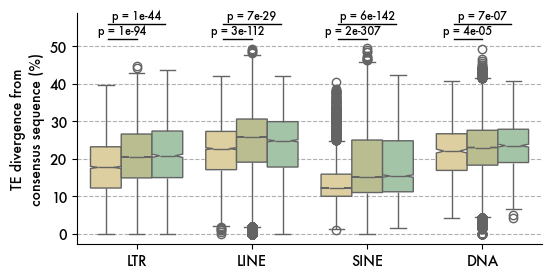

In [9]:
fig, ax = plt.subplots(figsize=(6, 3))

teclasses = ['LTR', 'LINE', 'SINE', 'DNA']

sns.boxplot(data=insertions_experiment_df.loc[insertions_experiment_df.teclass.isin(teclasses)], 
            x='teclass',
            y='perc_div',
            hue='group',
            palette=['#E7D595', '#BFC588', '#9FC9A4'],
            order=teclasses,
            notch=True,
            ax=ax)

for i, teclass in enumerate(teclasses):
    pval = stats.ranksums(insertions_experiment_df.loc[(insertions_experiment_df.teclass == teclass) & 
                                                       (insertions_experiment_df.group == 'other_genes'), 'perc_div'],
                          insertions_experiment_df.loc[(insertions_experiment_df.teclass == teclass) & 
                                                       (insertions_experiment_df.group == 'kznf_clusters'), 'perc_div'])
    
    plt.plot((i-0.25, i), (52, 52), color='k', lw=1)
    plt.text(i-0.125, 53, f'p = {pval[1]:.0e}', ha='center', size=8)
    pval = stats.ranksums(insertions_experiment_df.loc[(insertions_experiment_df.teclass == teclass) & 
                                                       (insertions_experiment_df.group == 'random'), 'perc_div'],
                          insertions_experiment_df.loc[(insertions_experiment_df.teclass == teclass) & 
                                                       (insertions_experiment_df.group == 'kznf_clusters'), 'perc_div'])
    
    plt.plot((i-0.25, i+0.25), (56, 56), color='k', lw=1)
    plt.text(i, 57, f'p = {pval[1]:.0e}', ha='center', size=8)
    
ax.set_ylabel('TE divergence from\nconsensus sequence (%)')
ax.set_xlabel('')
sns.despine()
ax.get_legend().remove()
plt.savefig('../figures/kznf_te_age.svg', bbox_inches='tight')
plt.show()

In [10]:
kznf2_bed = bt.BedTool('../data/gffs/kzfp_genes_only.gff')
other_genes2_bed = bt.BedTool('../data/gffs/GCF_009914755.1_T2T-CHM13v2.0_genes.gff').subtract(b=kznf2_bed)

genes_in_clusters_df = kznf_cluster_bed.coverage(other_genes2_bed).to_dataframe()
genes_in_random_df = []
for _ in range(10):
    random2_bed = kznf_cluster_bed.shuffle(g=t2t_genomefile)
    genes_in_random_df.append(random2_bed.coverage(other_genes2_bed).to_dataframe())
genes_in_random_df = pd.concat(genes_in_random_df)

genes_in_clusters_df['group'] = 'in_clusters'
genes_in_random_df['group'] = 'in_random'
gene_density_df = pd.concat([genes_in_clusters_df, genes_in_random_df]) \
                    .rename({'blockSizes': 'coverage',
                             'thickEnd': 'cluster_size'}, axis=1)
gene_density_df = gene_density_df.loc[gene_density_df.cluster_size >= 3]
gene_density_df['coverage'] *= 100

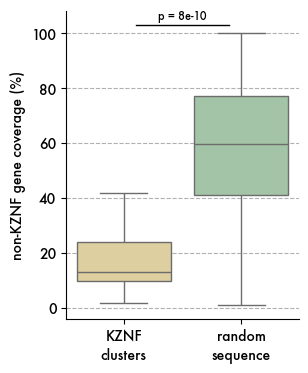

In [17]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.boxplot(data=gene_density_df, 
            x='group', 
            y='coverage',
            hue='group',
            palette=['#E7D595', '#9FC9A4'])

pval = stats.ranksums(gene_density_df.loc[gene_density_df.group == 'in_clusters', 'coverage'],
                      gene_density_df.loc[gene_density_df.group == 'in_random', 'coverage'])
ax.text(0.5, 105, f'p = {pval.pvalue:.0e}', ha='center', size=8)
ax.plot((0.1, 0.9), (103, 103), color='k', lw=1)


ax.set_ylabel('non-KZNF gene coverage (%)')
ax.set_xlabel('')
ax.set_xticks([0, 1])
ax.set_xticklabels(['KZNF\nclusters', 'random\nsequence'])
sns.despine()
plt.savefig('../figures/cluster_gene_density.svg', bbox_inches='tight')
plt.show()

In [12]:
colnames2 = ['chrom', 'kznf_start', 'kznf_stop',  
             'cluster_name', 'cluster_size', '_0', 
             'cluster_contents', 'te_chrom', 'te_start',
             'te_stop', 'te_name', 'sw_score',
             'strand', 'perc_div', 'perc_ins', 
             'perc_del', '_1', 'teclass', 
             '_2', '_3', '_4', '_5']
dropcols2 = ['_0', 'te_chrom', 'cluster_size', 'cluster_contents', '_1', '_2', '_3', '_4', '_5']

cluster_observations_df = kznf_cluster_bed \
    .filter(lambda x: int(x[4]) >= 3) \
    .intersect(te_bed, wa=True, wb=True) \
    .to_dataframe(names=colnames2).drop(dropcols2, axis=1)
cluster_observations_df['group'] = 'cluster'

cluster_complement_observations_df = kznf_cluster_bed \
    .filter(lambda x: int(x[4]) >= 3) \
    .complement(g=t2t_genomefile) \
    .intersect(te_bed, wa=True, wb=True) \
    .to_dataframe(names=colnames).drop(dropcols, axis=1)
cluster_complement_observations_df['group'] = 'cluster_complement'

cluster_experiment_df = pd.concat([cluster_observations_df, cluster_complement_observations_df])
cluster_experiment_df['tefam'] = cluster_experiment_df['teclass'].apply(lambda x: x.split('/')[-1])
cluster_experiment_df['teclass'] = cluster_experiment_df['teclass'].apply(lambda x: x.split('/')[0])

cluster_experiment_df.head()

,chrom,kznf_start,kznf_stop,cluster_name,te_start,te_stop,te_name,sw_score,strand,perc_div,perc_ins,perc_del,teclass,group,tefam
0,NC_060925.1,40316449,40419068,NC_060925.1_1,40316746,40317131,MLT1A,1698,+,20.3,0.8,5.4,LTR,cluster,ERVL-MaLR
1,NC_060925.1,40316449,40419068,NC_060925.1_1,40317138,40317463,L1M5,429,-,36.1,4.3,4.3,LINE,cluster,L1
2,NC_060925.1,40316449,40419068,NC_060925.1_1,40317463,40317761,AluSx,2281,-,12.1,0.0,0.0,SINE,cluster,Alu
3,NC_060925.1,40316449,40419068,NC_060925.1_1,40317761,40317881,L1M5,429,-,36.1,4.3,4.3,LINE,cluster,L1
4,NC_060925.1,40316449,40419068,NC_060925.1_1,40317941,40318059,L1ME2z,549,-,19.7,0.8,0.8,LINE,cluster,L1


In [18]:
test_dataframe = cluster_experiment_df.loc[cluster_experiment_df.teclass.isin(['LTR', 'LINE', 'SINE', 'DNA'])].copy()
tenames = sorted(set(test_dataframe.te_name))
odds_ratio_data = []
n = len(tenames)
i = 0
for tename in tenames:
    i += 1
    ncopies = len(test_dataframe.loc[test_dataframe.te_name == tename, 'te_name'])
    if ncopies < 100:
        continue
    test_dataframe.loc[:, 'iste'] = test_dataframe['te_name'].apply(lambda x: bool(x == tename))
    test_data = test_dataframe.groupby(['group', 'iste'])['te_name'].count().to_numpy()
    if len(test_data) != 4:
        continue
    print(f'{tename}\t{i}/{n}')
    fe = stats.fisher_exact(test_data.reshape((2, 2)))
    odds_ratio_data.append([tename, ncopies, 1/fe.statistic, fe.pvalue])

AluJb	1/1086
AluSx	2/1086
AluY	3/1086
AmnL2-1	5/1086
AmnSINE1	6/1086
AmnSINE2	7/1086
Arthur1	8/1086
Arthur1A	9/1086
Arthur1B	10/1086
Arthur2	12/1086
BLACKJACK	13/1086
CR1_Mam	22/1086
Chap1_Mam	23/1086
Chap1a_Mam	24/1086
Charlie1	25/1086
Charlie10	26/1086
Charlie13a	31/1086
Charlie14a	33/1086
Charlie15a	34/1086
Charlie16	36/1086
Charlie16a	37/1086
Charlie17a	39/1086
Charlie17b	40/1086
Charlie18a	41/1086
Charlie19a	42/1086
Charlie1a	43/1086
Charlie1b	45/1086
Charlie20a	47/1086
Charlie21a	48/1086
Charlie23a	50/1086
Charlie25	52/1086
Charlie26a	53/1086
Charlie29a	54/1086
Charlie2a	56/1086
Charlie2b	57/1086
Charlie4	63/1086
Charlie4a	64/1086
Charlie4z	65/1086
Charlie5	66/1086
Charlie7	68/1086
Charlie7a	69/1086
Charlie8	71/1086
Charlie9	72/1086
Cheshire	73/1086
DNA1_Mam	75/1086
ERV24B_Prim-int	76/1086
ERV24_Prim-int	77/1086
ERV3-16A3_I	78/1086
ERV3-16A3_LTR	79/1086
ERVL-B4-int	80/1086
ERVL-E-int	81/1086
ERVL-int	82/1086
ERVL47-int	83/1086
EUTREP7	88/1086
EutTc1-N2	111/1086
EuthAT-2	112/1086


In [19]:
or_df = pd.DataFrame(odds_ratio_data, columns=['tename', 'ncopies', 'OR', 'pval']) \
    .sort_values('OR') \
    .reset_index(drop=True) \
    .merge(cluster_experiment_df.groupby(['te_name'])['perc_div'] \
                        .median() \
                        .reset_index() \
                        .rename({'perc_div': 'median_perc_div',
                                 'te_name': 'tename'}, axis=1), on='tename')

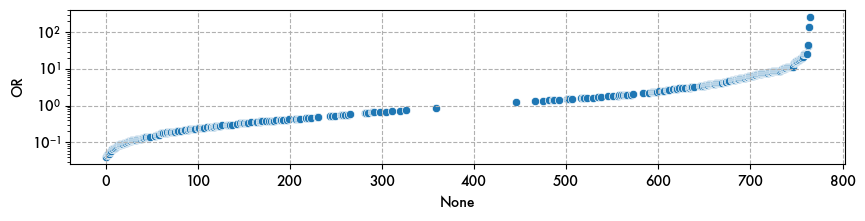

In [20]:
fig, ax = plt.subplots(figsize=(10, 2))
sns.scatterplot(or_df.loc[or_df.pval < 0.01], x=or_df.loc[or_df.pval < 0.01].index, y='OR')
ax.set_yscale('log')

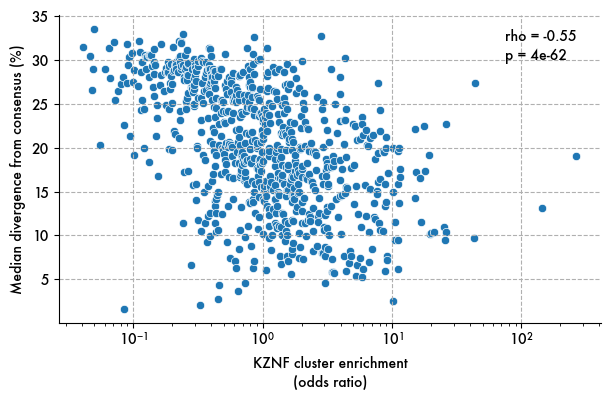

In [21]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(data=or_df, x='OR', y='median_perc_div')
rho, pval = stats.spearmanr(or_df.median_perc_div, or_df.OR)
plt.text(75, 30, f'rho = {rho:.2f}\np = {pval:.0e}')
ax.set_xlabel('KZNF cluster enrichment\n(odds ratio)')
ax.set_ylabel('Median divergence from consensus (%)')
ax.set_xscale('log')
sns.despine()
plt.savefig('../figures/or_age_correlation.svg', bbox_inches='tight')